In [25]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns



In [2]:
# Load datasets
train_data = pd.read_csv('/content/BCS-DBT-labels-train-v2.csv')
val_data = pd.read_csv('/content/BCS-DBT-labels-validation-PHASE-2-Jan-2024.csv')
test_data = pd.read_csv('/content/BCS-DBT-labels-test-PHASE-2.csv')

In [3]:
# Combine train and validation for preprocessing consistency
combined_data = pd.concat([train_data, val_data], keys=["train", "val"])

In [4]:
# Encode categorical variables
label_encoders = {}
categorical_columns = ['PatientID', 'StudyUID', 'View']

In [5]:
for column in categorical_columns:
    label_encoders[column] = LabelEncoder()
    combined_data[column] = label_encoders[column].fit_transform(combined_data[column])

In [6]:
# Separate features and labels
X = combined_data.drop(['PatientID', 'StudyUID', 'Normal', 'Actionable', 'Benign', 'Cancer'], axis=1)
y = combined_data['Cancer']

In [7]:
# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [8]:
# Split train and validation back
X_train, X_val, y_train, y_val = train_test_split(X[:len(train_data)], y[:len(train_data)], test_size=0.2, random_state=42)

In [9]:
# Prepare test data
for column in categorical_columns:
    test_data[column] = test_data[column].apply(
        lambda x: label_encoders[column].transform([x])[0]
        if x in label_encoders[column].classes_ else -1
    )

X_test = test_data.drop(['PatientID', 'StudyUID', 'Normal', 'Actionable', 'Benign', 'Cancer'], axis=1)
y_test = test_data['Cancer']
X_test = scaler.transform(X_test)

In [10]:
# Reshape data for CNN
X_train_cnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val_cnn = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test_cnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [14]:
# Build the CNN model with adjusted kernel size
model = Sequential([
    Conv1D(32, 1, activation='relu', input_shape=(X_train_cnn.shape[1], 1)),  # Adjusted kernel size to 1
    MaxPooling1D(2, padding='same'),  # Adjust padding to handle small input sizes
    Dropout(0.2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [15]:
# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train_cnn, y_train,
    validation_data=(X_val_cnn, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/50
479/479 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.9854 - loss: 0.1875 - val_accuracy: 0.9961 - val_loss: 0.0288
Epoch 2/50
479/479 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9953 - loss: 0.0350 - val_accuracy: 0.9961 - val_loss: 0.0273
Epoch 3/50
479/479 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9962 - loss: 0.0275 - val_accuracy: 0.9961 - val_loss: 0.0264
Epoch 4/50
479/479 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9959 - loss: 0.0290 - val_accuracy: 0.9961 - val_loss: 0.0267
Epoch 5/50
479/479 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9955 - loss: 0.0323 - val_accuracy: 0.9961 - val_loss: 0.0261
Epoch 6/50
479/479 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9963 - loss: 0.0262 - val_accuracy: 0.9961 - val_loss: 0.0261
Epoch 7/50
479/479 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9961 - loss: 0.0268 - val_accuracy: 0.9961 - val_loss: 0.0256
Epoch 8/50
479/479 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9959 - loss: 0.0282 - val_accuracy: 0.

In [16]:
# Evaluate the model
val_loss, val_accuracy = model.evaluate(X_val_cnn, y_val, verbose=0)
test_loss, test_accuracy = model.evaluate(X_test_cnn, y_test, verbose=0)

In [17]:
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Validation Accuracy: 0.9961
Test Accuracy: 0.9651


In [20]:
# Generate predictions
y_pred = (model.predict(X_test_cnn) > 0.5).astype(int)

# Confusion Matrix and Metrics
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Confusion Matrix:
[[1661    0]
 [  60    0]]


In [21]:
# Classification Report
class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1661
           1       0.00      0.00      0.00        60

    accuracy                           0.97      1721
   macro avg       0.48      0.50      0.49      1721
weighted avg       0.93      0.97      0.95      1721



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


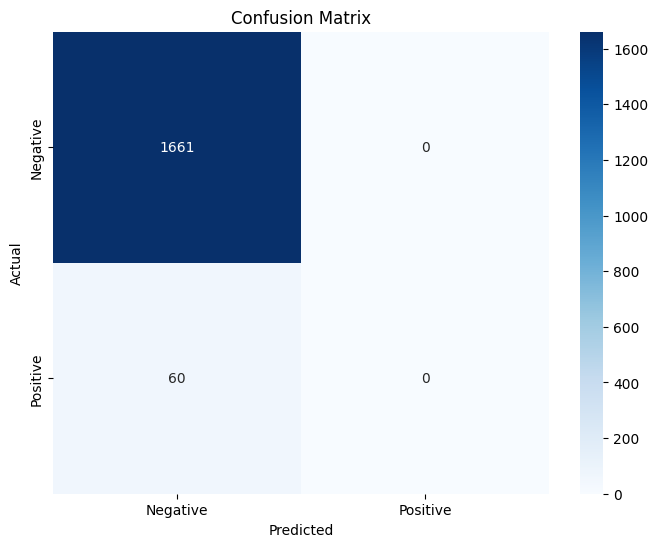

In [26]:
# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

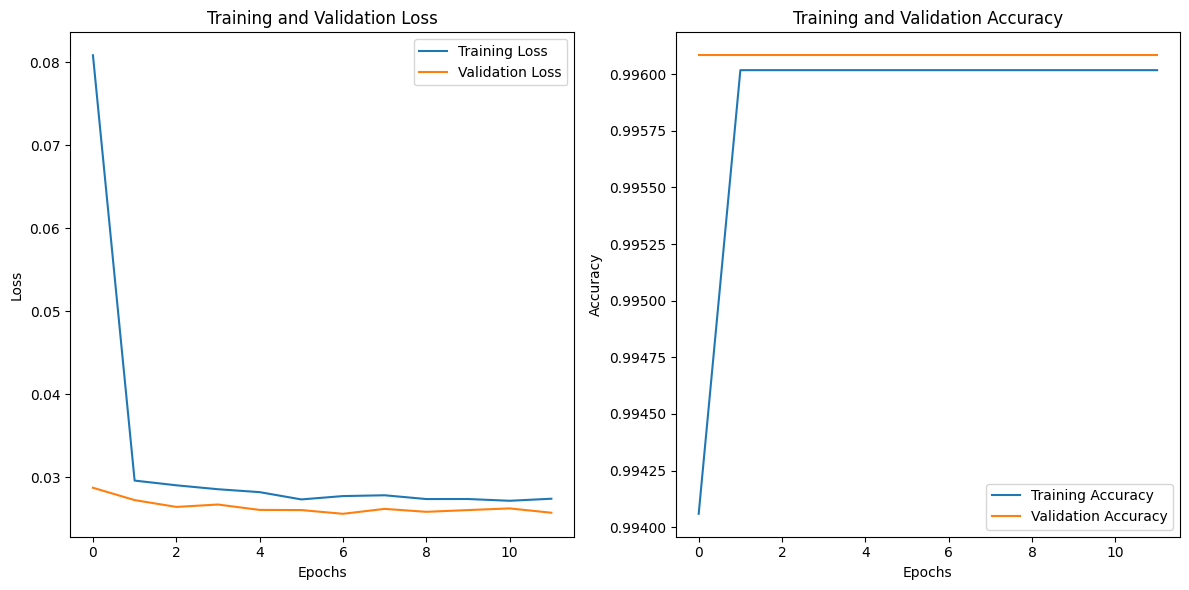

In [34]:
# Plot Training History
plt.figure(figsize=(12, 6))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()